# deepCR: Spectroscopic Edition

In [1]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

import glob
import os
import re
import shutil

In [2]:
class DESIImage():
    def __init__(self, pix, mask, ivar):
        self.pix = pix
        self.mask = mask
        self.ivar = ivar
        self.camera = "R3"

In [ ]:
ROOT = os.curdir()

In [4]:
def get_images(image_names):
    big = []
    big_mask = []
    
    # Loop over the list of image names and extract all the full names
    for n in image_names:
        # Checks to see if we compressed the files or not
        if len(n) > 6:
            image_name = os.path.join(ROOT, "data", f"{n}.fits")
        else:
            image_name = os.path.join(ROOT, "data", f"{n}.fits.fz")
        hdus = fits.open(image_name)
        
        # Loads the image, then loads the corresponding CR mask.
        working = hdus["IMAGE"].data
        working_mask = hdus["MASK"].data
        
        # Loops over the image and slices it up into 256x256 squares.
        # This is the same slicing code I wrote that reproduced the deepCR hubble results
        for i in range(128, working.shape[0] - 128 - 255, 256):
            for j in range(128, working.shape[1] - 128 - 255, 256):
                big.append(working[i:i+256, j:j+256].reshape(1, 256, 256))
                big_mask.append(working_mask[i:i+256, j:j+256].reshape(1, 256, 256))
                
        for i in range(0, working.shape[0] - 255, 256):
            for j in range(0, working.shape[1] - 255, 256):
                big.append(working[i:i+256, j:j+256].reshape(1, 256, 256))
                big_mask.append(working_mask[i:i+256, j:j+256].reshape(1, 256, 256))

            
    # Concatenates the images into nice numpy arrays
    big = np.concatenate(big)
    big_mask = np.concatenate(big_mask)

    return (big, big_mask)

def pretty_disp(img):
    zscale = ZScaleInterval()
    norm = ImageNormalize(img, zscale)

    fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
    ax.imshow(img, cmap='gray', origin="lower", interpolation="none", norm=norm)

3607
1203


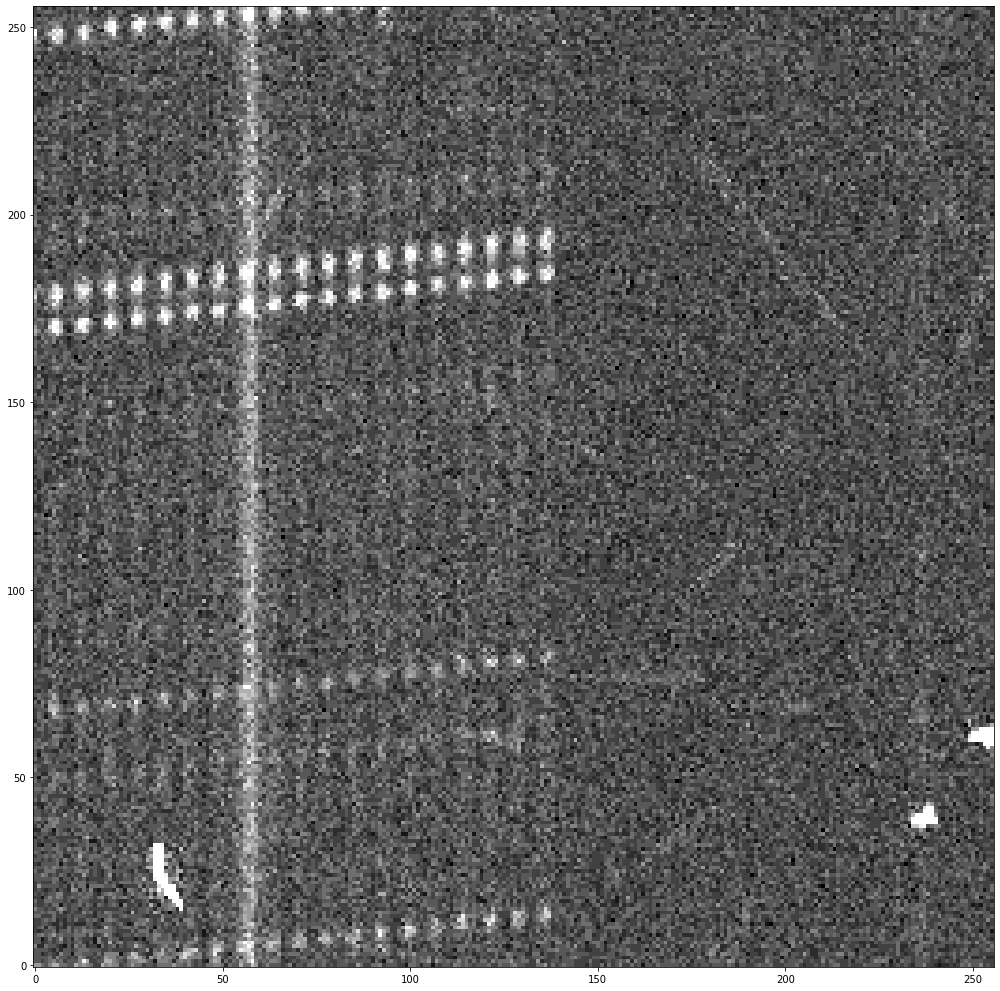

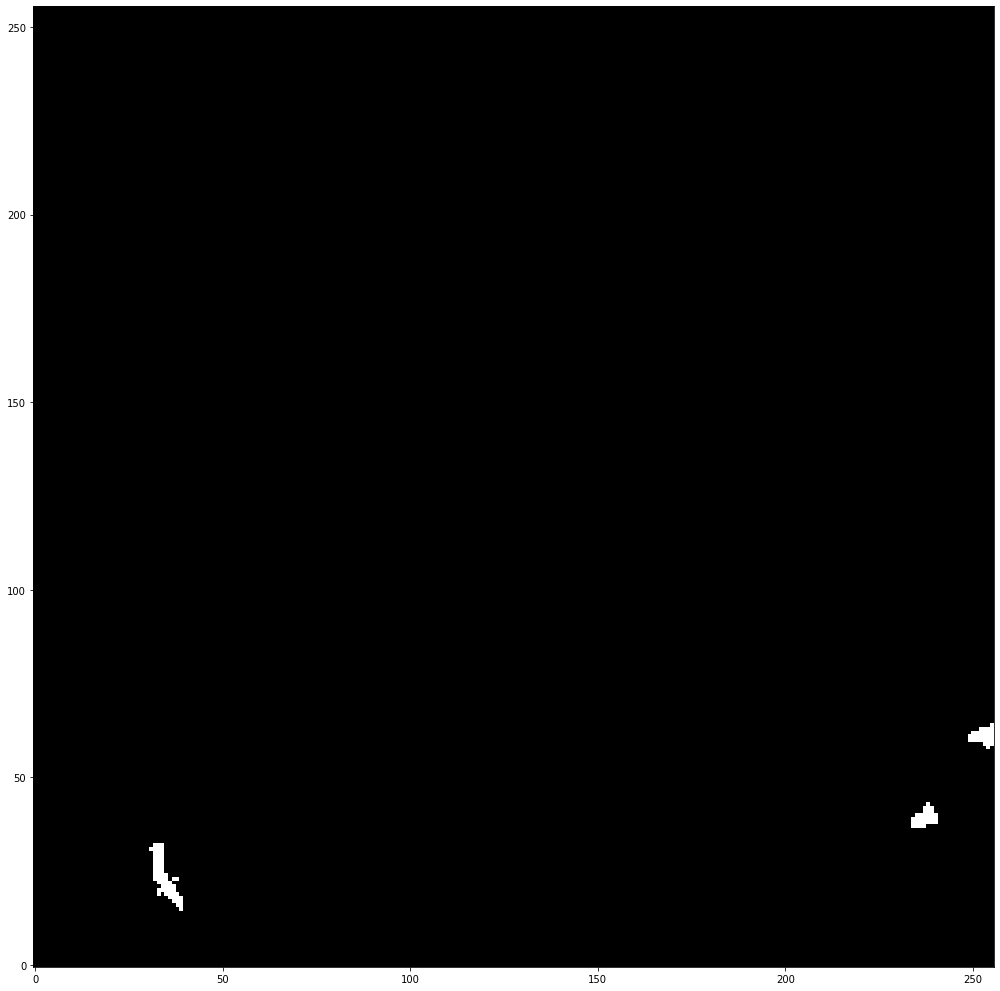

In [6]:
# Strips out the actual name using magic regex to ignore anything with two digit names
# This is thus designed to use images 0-9 as training data and 10-12 as validation
long_names = [f.split(".")[0] for f in os.listdir(os.path.join(ROOT, "data")) if re.search(r'^[0-9]?-R[0-9]?', f)]

# D for data, m for masks
d, m = get_images(long_names)

# Need to convert this to be binary (1, 0)
m = m == 255

im_train, im_test, mask_train, mask_test = train_test_split(d, m, random_state = 21)
print(len(im_train))
print(len(im_test))

pretty_disp(d[-1])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(14, 28), tight_layout=True)
ax.imshow(m[-1], cmap='gray', origin="lower")

In [7]:
from deepCR import deepCR
from deepCR import train
from deepCR import roc

No GPU detected on this device! Training on CPU.
Begin first 1 epochs of training
Use batch statistics for batch normalization; keep running statistics to be used in phase1

----------- epoch = 1 -----------
[TPR=0.842, FPR=0.000] @threshold = 0.5
loss = 0.0046

Continue onto next 1 epochs of training
Batch normalization running statistics frozen and used



/Users/dylan/miniconda3/lib/python3.7/site-packages/deepCR/training.py:247: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(self.img0[0, 0].detach().cpu().numpy()), cmap='gray')
/Users/dylan/miniconda3/lib/python3.7/site-packages/deepCR/training.py:247: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(self.img0[0, 0].detach().cpu().numpy()), cmap='gray')


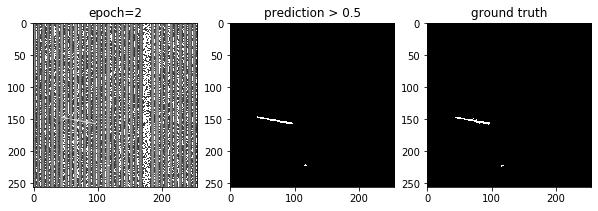

----------- epoch = 2 -----------
[TPR=0.856, FPR=0.000] @threshold = 0.5
loss = 0.0025



In [8]:
# This is going to take an ungodly amount of time to train on my laptop. Sad. 
trainer = train(im_train, mask_train, name="manta_spectro",
                epoch=2, save_after=5, plot_every=2, use_tqdm=False)
trainer.train()
filename = trainer.save()

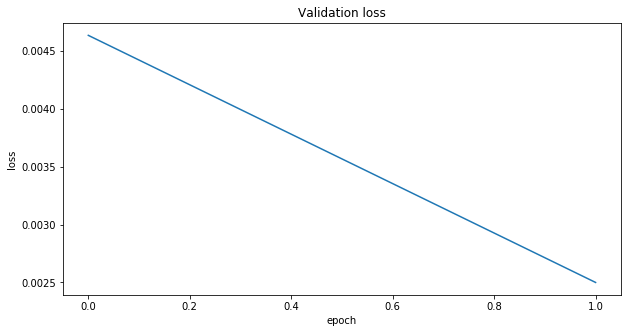

In [9]:
trainer.plot_loss()

In [ ]:
mdl = deepCR(mask="2020-07-09_manta_spectro_epoch8.pth", hidden=32)
names = [#"preproc-r3-00055611.fits", "preproc-r0-00051114.fits", 
         #"preproc-r1-00047428.fits", "10-R0.fits.fz", 
         "11-R4.fits.fz", "12-R3.fits.fz"]

for n in names:
    hdus = fits.open(os.path.join(os.curdir, "data", n))
    working = hdus["IMAGE"].data

    m = mdl.clean(working, inpaint=False)

    hd0 = fits.PrimaryHDU()
    hd1 = fits.ImageHDU(working, name="IMAGE")
    hd2 = fits.ImageHDU(m * 255, name="MASK")
    hdul = fits.HDUList([hd0, hd1, hd2])
    
    name = n.split(".")[0]
    hdul.writeto(f"data/{name}-run.fits.fz", overwrite=True)
    
    print(f"Complete: {name}-run.fits.fz")

Complete: 11-R4.fits.fz-run.fits.fz


In [11]:
# mdl = deepCR(mask=filename, hidden=32)
mdl = deepCR(mask="2020-07-09_manta_spectro_epoch8.pth", hidden=32)

im_real, mask_real = get_images(["preproc-r3-00055611", "preproc-r0-00051114", "preproc-r1-00047428"])
im_test, mask_test = get_images(["10-R1", "11-R1", "12-R4"])

im_real = im_real[::2]
mask_real = mask_real[::2]

im_test = im_test[::2]
mask_test = mask_test[::2]

mask_test = mask_test > 0
mask_real = mask_real > 0 # Idk why its set to 16 in the real data or if its even always 16

(fake_tpr, fake_fpr), (fake_tpr_d, fake_fpr_d) = roc(mdl, im_test, mask_test, dilate=True, rad=1)
(tpr, fpr), (tpr_d, fpr_d) = roc(mdl, im_real, mask_real, dilate=True, rad=1)

100%|██████████| 722/722 [14:05<00:00,  1.17s/it]


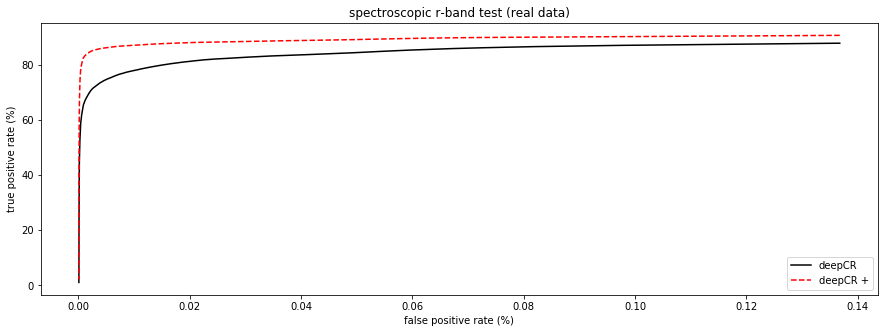

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

# R-band camera
x_max = 1
ax.plot(fake_fpr, fake_tpr, "k", label="deepCR")
ax.plot(fake_fpr, fake_tpr_d, "r--", label="deepCR +")
# ax.set_xlim(0, x_max)
# ax.set_ylim(40, 100)
ax.set_title("spectroscopic r-band test (real data)")
ax.set_xlabel("false positive rate (%)")
ax.set_ylabel("true positive rate (%)")
ax.legend(loc=4)

plt.show()

# print(tpr1)

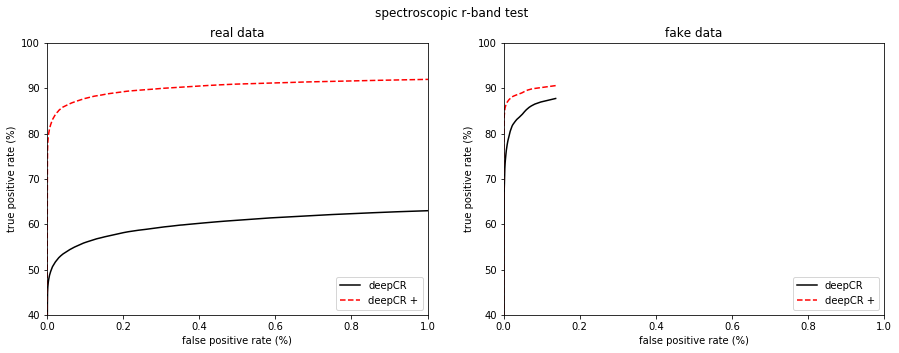

In [13]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

# Extragalactic field
x_max = 1
ax[0].plot(fpr, tpr, "k", label="deepCR")
ax[0].plot(fpr, tpr_d, "r--", label="deepCR +")
ax[0].set_xlim(0, x_max)
ax[0].set_ylim(40, 100)
ax[0].set_title("real data")
ax[0].set_xlabel("false positive rate (%)")
ax[0].set_ylabel("true positive rate (%)")
ax[0].legend(loc=4)

# Globular cluster
ax[1].plot(fake_fpr, fake_tpr, "k", label="deepCR")
ax[1].plot(fake_fpr, fake_tpr_d, "r--", label="deepCR +")
ax[1].set_xlim(0, x_max)
ax[1].set_ylim(40, 100)
ax[1].set_title("fake data")
ax[1].set_xlabel("false positive rate (%)")
ax[1].set_ylabel("true positive rate (%)")
ax[1].legend(loc=4)

fig.suptitle("spectroscopic r-band test")
plt.savefig("deepCR-test.png")

In [245]:
# This fixes the tqdm progress bar if it breaks
# Typically it breaks when you stop the cell during the run
from tqdm import tqdm
tqdm._instances.clear()

In [10]:
def reject_sdss_single_rewrite(pix, ivar,selection,psf_gradients,nsig,cfudge,c2fudge):
    #print("starting with nsig=%2.1f cfudge=%2.1f c2fudge=%2.1f"%(nsig,cfudge,c2fudge))   
    
    # We only consider data 1 pixel off from CCD edge 
    # because we need to use pixels to either side.
    # Then we flatten the pixels to ease data manip.
    tselection = selection[1:-1,1:-1]
    tpix = pix[1:-1,1:-1][tselection]
    tpixivar = ivar[1:-1,1:-1][tselection]

    # There are 4 axis (horizontal,vertical,and 2 diagonals).
    # For each axis, there is a pair of two pixels on each side of the pixel of interest.
    # psf is precomputed for each camera
    # using psf_for_cosmics.py --psffile psf-{b,r,z}0-00000000.fits
    # today based on data challenge 2 results , psf files from
    # /project/projectdirs/desi/spectro/redux/alpha-3/calib2d/psf/20150107
    naxis = psf_gradients.size
    
    # pairpix is the pixel values
    # pairivar their inverse variance (accounting for pre-existing mask)
    pairpix = np.zeros((naxis, 2, tpix.size))
    pairivar = np.zeros((naxis, 2, tpix.size))
    
    # Right and then left by slicing such that the area we use tselection over is to the right
    # and then to the left.
    pairpix[0, 0] = pix[1:-1, 2:][tselection]
    pairpix[0, 1] = pix[1:-1, :-2][tselection]
    pairivar[0, 0] = ivar[1:-1, 2:][tselection]
    pairivar[0, 1] = ivar[1:-1, :-2][tselection]
    
    # Do the same as before, but now we do it along the y axis, so bottom then top.
    pairpix[1, 0] = pix[2:, 1:-1][tselection]
    pairpix[1, 1] = pix[:-2, 1:-1][tselection]
    pairivar[1, 0] = ivar[2:, 1:-1][tselection]
    pairivar[1, 1] = ivar[:-2, 1:-1][tselection]
    
    # Move along the diagonal axes, so we do lower right then upper left here
    pairpix[2, 0] = pix[2:, 2:][tselection]
    pairpix[2, 1] = pix[:-2, :-2][tselection]
    pairivar[2, 0] = ivar[2:, 2:][tselection]
    pairivar[2, 1] = ivar[:-2, :-2][tselection]
    
    # Move along the other diagonal, lower left then upper right.
    pairpix[3, 0] = pix[2:, :-2][tselection]
    pairpix[3, 1] = pix[:-2, 2:][tselection]
    pairivar[3, 0] = ivar[2:, :-2][tselection]
    pairivar[3, 1] = ivar[:-2, 2:][tselection]
    
    for a in range(naxis):
        for i in range(2):
            # This is the pixels that have an ivar of 0, so we want to ignore them.
            jj = (pairivar[a, i] == 0)
            
            # Replace the 0 ivars with the value of the pixel in the middle
            # For ignoring?
            pairpix[a, i, jj] = tpix[jj] 
            pairivar[a, i, jj] = tpixivar[jj]
    
    # back and sigmaback are the average values of each pair and their error
    # (same notation as SDSS code)
    # Question, do you really need pairivar > 0? The previous loop removes all ivar of 0
    # and it shouldn't ever be negative (it's a squared quantity)
    # I suppose if tpixivar is 0 as well but then we're ignoring the whole pixel anyway.
    # In fact pairivar == 0 should almost never be 1 because of the previous loop unless the above
    # cond is true wtffff
    back = np.sum(pairpix * (pairivar > 0), axis=1) * 0.5
    sigmaback = np.sqrt(np.sum((pairivar > 0) / (pairivar + (pairivar == 0)), axis=1)) * 0.5
    
    #print("mean pix = %f"%np.mean(tpix))
    #print("mean back = %f"%np.mean(back))
    #print("mean sigmaback = %f"%np.mean(sigmaback))
    
    # First criterion: signal in pix must be significantly higher than 
    # neighbours average (back) in all directions
    # JG comment: this does not look great for muon tracks that are perfectly 
    # aligned with one the axis.
    # I change the algorithm to accept 3 out of 4 valid tests
    first_criterion = np.ones(tpix.shape)
    nonullivar = tpixivar > 0
    tmp = np.zeros(tpix.shape)
    tmp[nonullivar] = tpix[nonullivar] - nsig / np.sqrt(tpixivar[nonullivar])
    for a in range(naxis) :
        first_criterion += (tmp > back[a])
    first_criterion = (first_criterion >= 3)

    # Second criterion: rejected if at least for one axis
    # the values back are not consistent with PSF given the central
    # pixel value
    # Here the number of sigmas is the parameter cfudge
    # c2fudge alters the PSF 
    # But how??
    second_criterion = np.zeros(tpix.shape, dtype="bool")
    tmp = np.zeros(tpix.shape)
    tmp[nonullivar] = tpix[nonullivar] - cfudge / np.sqrt(tpixivar[nonullivar])
    for a in range(naxis):
        second_criterion |= (tmp * c2fudge * psf_gradients[a] > (back[a] + cfudge * sigmaback[a]))

    #print("npix selected                       = %d"%tpix.size)
    #print("npix rejected 1st criterion         = %d"%np.sum(first_criterion))
    #print("npix rejected 1st and 2nd criterion = %d"%np.sum(first_criterion&second_criterion))
    
    # Remap rejections to original shape
    rejection = np.zeros(pix.shape).astype(bool)
    rejection[1:-1, 1:-1][tselection] = (first_criterion & second_criterion).reshape(tpix.shape)
    return rejection

def reject_sdss_rewrite(img, nsig=6.,cfudge=3.,c2fudge=0.5,niter=6,dilate=True):
    #print("starting with nsig=%2.1f cfudge=%2.1f c2fudge=%2.1f"%(nsig,cfudge,c2fudge))
#     t1 = time.time()
    
    # Implicitly sets any masking pixels already set to have an ivar of 0
    # So they get ignored later
    tivar = img.ivar * (img.mask == 0) * (img.ivar > 0) # Is ivar > 0 necessary?
    
    # those gradients have been computed using the code desi_compute_psf_gradients
    # 2019-04-17: switch from sharpest psf among all fibers and wavelength to mean psf on the CCD
    # this is to avoid being sensitive to noisy psf at short or long wavelength.
    # An analysis of real darks combined with real continuum suggest a best value for c2fudge=0.8
    # See https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=4893
    # A new analysis using arc lines gives a conservative value c2fudge=0.5
    # see https://github.com/desihub/desispec/issues/762

    band = img.camera[0].lower()
    if band == 'b':
        # desi_compute_psf_gradients -i $DESI_SPECTRO_CALIB/spec/sp2/psf-b2-20190308.fit
        psf_gradients = np.array([0.758221, 0.771945, 0.570183, 0.592199])
    elif band == 'r':
        # desi_compute_psf_gradients -i $DESI_SPECTRO_CALIB/spec/sp2/psf-r2-20190308.fits
        psf_gradients = np.array([0.819245, 0.847529, 0.617514, 0.656629])
    elif band == 'z':
        # desi_compute_psf_gradients -i $DESI_SPECTRO_CALIB/spec/sp2/psf-z2-20190308.fits
        psf_gradients = np.array([0.829552, 0.862828, 0.633424, 0.664144])
    else :
        #print("do not have psf info for band='%s'"%band)
        raise KeyError("do not have psf info for band='%s'"%band)

    # Pixels with a sigma deviation > nsig are selected
    selection = ((img.pix * np.sqrt(tivar)) > nsig)
    
    rejected  = reject_sdss_single_rewrite(img.pix, tivar, selection, psf_gradients, nsig, cfudge, c2fudge)
    
    #print("first pass: %d pixels rejected"%(np.sum(rejected)))
    
    if niter > 0:        
        for iteration in range(niter):
            # if np.sum(rejected)==0 : break
            neighbors = np.zeros(rejected.shape, dtype=bool)
            
            # left and right neighbors
            neighbors[1:,:]  |= rejected[:-1,:]
            neighbors[:-1,:] |= rejected[1:,:]
            neighbors[:,1:]  |= rejected[:,:-1]
            neighbors[:,:-1] |= rejected[:,1:]
            
            # adding diagonals (not in original SDSS version)
            neighbors[1:, 1:] |= rejected[:-1, :-1]
            neighbors[:-1, :-1] |= rejected[1:, 1:]
            neighbors[1:, :-1] |= rejected[:-1, 1:]
            neighbors[:-1, 1:] |= rejected[1:, :-1]
            neighbors &= (rejected == False) # Exclude already rejected pixels
            tivar[rejected] = 0. # Mask already rejected pixels for the calculation of the background of the neighbors

            # Rerun with more strict cuts
            newrejected = reject_sdss_single_rewrite(img.pix,tivar,neighbors,psf_gradients, 3., 0., c2fudge)
                
            #print("at iter %d: %d new pixels rejected"%(iteration,np.sum(newrejected)))
            if np.sum(newrejected) < 1:            
                break
            rejected |= newrejected

    if dilate:
        #print("dilating cosmic ray mask")
        # now apply the dilatation included in sdssproc.pro
        # in IDL it is crmask = dilate(crmask, replicate(1,3,3)
        tmp = rejected.copy()
        rejected[1:, :]  |= tmp[:-1, :]
        rejected[:-1, :] |= tmp[1:, :]
        rejected[:, 1:]  |= tmp[:, :-1]
        rejected[:, :-1] |= tmp[:, 1:]
        rejected[1:, 1:]  |= tmp[:-1, :-1]
        rejected[:-1, :-1]  |= tmp[1:, 1:]
        rejected[1:, :-1]  |= tmp[:-1, 1:]
        rejected[:-1, 1:]  |= tmp[1:, :-1]
        
#         k = np.ones((3, 3))
#         rejected = ndimage.binary_dilation(rejected, k)
#         print(f"same? {np.all(rejected == rejected2)}")
        
        # Apply binary closure repair defined in joincosmics.
        #print('Repairing gaps in cosmic ray mask')
#         rejected = repair_mask.repair(rejected)

#     t2 = time.time()
#     print("end : {} pixels rejected in {:3.1f} sec".format(np.sum(rejected), t2 - t1))
    return rejected

def reject_cosmic_rays_rewrite(img, nsig=5, cfudge=3., c2fudge=0.9, niter=100, dilate=True) :
    """Cosmic ray rejection
    Input is a pre-processed image : desispec.Image
    The image mask is modified
    Args:
       img: input desispec.Image
    """
    rejected = reject_sdss_rewrite(img,nsig=nsig,cfudge=cfudge,c2fudge=c2fudge,niter=niter,dilate=dilate)
    
#     print(np.sum(rejected))
    
    temp = np.zeros_like(img.mask, dtype="bool")
    temp[rejected] = True
    return temp

In [201]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter

In [268]:
def roc_single_desi(img, ivar, true_mask):
    tpr = []
    fpr = []
    
    single_slice = DESIImage(img, np.zeros_like(img), ivar)
    desi_mask = reject_cosmic_rays_rewrite(single_slice)

    # Finding the tpr and fpr for this slice.
    equals = (desi_mask > 0) == (true_mask > 0)

    # TPR: When the desi and true masks are the same, and the true mask is a cosmic
    # FPR: When desi mask is cosmic and true mask is not.
    # If there were no cosmics in this block, I'm not sure what to put the true
    # positive rate at. 100? 0? 
#     if np.sum(true_mask[s] > 0) != 0:
    tpr.append(np.sum(equals & (true_mask > 0)) / np.sum(true_mask > 0))
    fpr.append(np.sum(desi_mask > 0 & (true_mask == 0)) / np.sum(true_mask == 0))
            
#     def roc_helper(s):
#         # Slicing the img and ivar into smaller chunks
#         t_i = img[s]
#         t_iv = ivar[s]

#         # Running the image through the reject method
#         single_slice = DESIImage(t_i, np.zeros_like(t_i), t_iv)
#         desi_mask = reject_cosmic_rays_rewrite(single_slice)

#         # Finding the tpr and fpr for this slice.
#         equals = (desi_mask > 0) == (true_mask[s] > 0)

#         # TPR: When the desi and true masks are the same, and the true mask is a cosmic
#         # FPR: When desi mask is cosmic and true mask is not.
#         # If there were no cosmics in this block, I'm not sure what to put the true
#         # positive rate at. 100? 0? 
#         if np.sum(true_mask[s] > 0) != 0:
#             tpr.append(np.sum(equals & (true_mask[s] > 0)) / np.sum(true_mask[s] > 0))
#             fpr.append(np.sum(desi_mask > 0 & (true_mask[s] == 0)) / np.sum(true_mask[s] == 0))
    
#     for i in range(0, img.shape[0] - 255, 256):
#         for j in range(0, img.shape[1] - 255, 256):
#             s = np.s_[i:i+256, j:j+256]
#             roc_helper(s)
    
#     for i in range(128, img.shape[0] - 128 - 255, 256):
#         for j in range(128, img.shape[1] - 128 - 255, 256):
#             # Slice object because abstraction
#             s = np.s_[i:i+256, j:j+256]
#             roc_helper(s)
            
    tpr = np.asarray(tpr)
    fpr = np.asarray(fpr)
    print(tpr, fpr)
    # Times 100 to convert to percents
    return (tpr * 100, fpr * 100)

def roc_desi(images):
    tpr = []
    fpr = []
    for name in images:
        temp = fits.open(f"data/{name}.fits")
        
        # S for single
        tpr_s, fpr_s = roc_single_desi(temp["IMAGE"].data, temp["IVAR"].data, temp["MASK"].data)
        
        tpr.append(tpr_s)
        fpr.append(fpr_s)
        
    # Combines all of the individual images cosmic rays together.
    tpr = np.concatenate(tpr)
    fpr = np.concatenate(fpr)
    
    # This finds the indices that would sort the fpr low to high
    # Then sorts both fpr and tpr by that ordering, thus maintaining
    # the fpr-tpr parity but sorting by fpr.
    ind = np.argsort(fpr)
    fpr = fpr[ind]
    tpr = tpr[ind]
    
    # Smoothing the curve by averaging over small increments.
    tpr_smooth = []
    fpr_smooth = []
    
    width = 0.02
    for i in np.arange(width, np.max(fpr) + width, width):
        # Takes everything within the given range, inclusive on lower bound.
        # This can be used as indices thanks to numpy magic
        to_use = (fpr < i) & (fpr >= i - width)
        tpr_smooth.append(np.mean(tpr[to_use]))
        fpr_smooth.append(i - width / 2)
    
    # Stripping out the nans because they're kind of annoying.
    ind = ~np.isnan(tpr_smooth)
    tpr_smooth = np.asarray(tpr_smooth)[ind]
    fpr_smooth = np.asarray(fpr_smooth)[ind]
    
    # Smoothing out that curve a little bit more I guess.
    tpr_smooth = gaussian_filter(tpr_smooth, sigma=5)
#     return (tpr_smooth, fpr_smooth)
    return(tpr, fpr)

In [281]:
tpr_desi, fpr_desi = roc_desi(["preproc-r3-00055611", "preproc-r0-00051114", "preproc-r1-00047428"])
tpr_desi_f, fpr_desi_f = roc_desi(["10", "12", "9"])

[1.] [0.00897579]
[1.] [0.00187874]
[0.99980481] [0.00105957]


/Users/dylan/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dylan/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.9999503] [0.00483687]
[0.99726376] [0.00607569]
[0.9936081] [0.00469549]


[ 99.98048146 100.         100.        ]
[0.10595724 0.18787421 0.89757871]


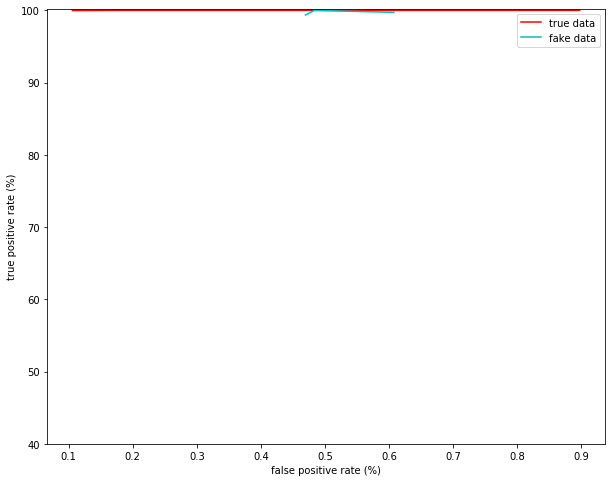

In [282]:
print(tpr_desi)
print(fpr_desi)
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel("false positive rate (%)")
plt.ylabel("true positive rate (%)")
plt.ylim(40, 100.2)
plt.plot(fpr_desi, tpr_desi, label="true data", c="r")
plt.plot(fpr_desi_f, tpr_desi_f, label="fake data", c="c")
plt.legend()
plt.savefig("desi-roc.png")

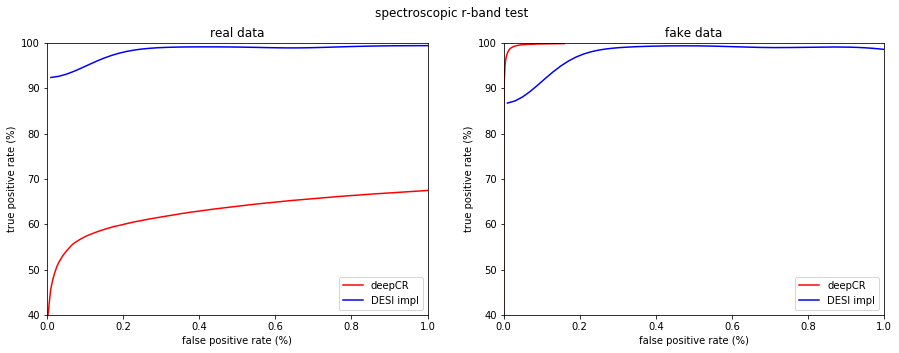

In [251]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

# Extragalactic field
x_max = 1
ax[0].plot(fpr, tpr, "r", label="deepCR")
# ax[0].plot(fpr, tpr_d, "r--", label="deepCR +")
ax[0].plot(fpr_desi, tpr_desi, "b", label="DESI impl")
# ax[0].plot(eg_fpr2, eg_tpr_d2, "b--", label="DESI impl +")
ax[0].set_xlim(0, x_max)
ax[0].set_ylim(40, 100)
ax[0].set_title("real data")
ax[0].set_xlabel("false positive rate (%)")
ax[0].set_ylabel("true positive rate (%)")
ax[0].legend(loc=4)

# Globular cluster
ax[1].plot(fake_fpr, fake_tpr, "r", label="deepCR")
# ax[1].plot(fake_fpr, fake_tpr_d, "r--", label="deepCR +")
ax[1].plot(fpr_desi_f, tpr_desi_f, "b", label="DESI impl")
# ax[0].plot(eg_fpr2, eg_tpr_d2, "b--", label="paper +")
ax[1].set_xlim(0, x_max)
ax[1].set_ylim(40, 100)
ax[1].set_title("fake data")
ax[1].set_xlabel("false positive rate (%)")
ax[1].set_ylabel("true positive rate (%)")
ax[1].legend(loc=4)

fig.suptitle("spectroscopic r-band test")
plt.savefig("deepCR-test.png")

60.0
(256, 256)


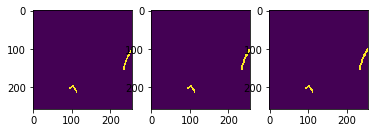

In [13]:
test = fits.open("data/preproc-r1-00047428.fits")
print(test["IMAGE"].header["EXPTIME"])

s = np.s_[3000: 3256, -257: -1]

fig, ax = plt.subplots(1, 3)
ax[0].imshow(test["MASK"].data[s])

t_i = test["IMAGE"].data[s]
t_iv = test["IVAR"].data[s]
test_slice = DESIImage(t_i, np.zeros_like(t_i), t_iv)
m1 = reject_cosmic_rays_rewrite(test_slice)
ax[1].imshow(m1)

t_i = np.pad(t_i, 1)
t_iv = np.pad(t_iv, 1, mode="reflect")
test_slice = DESIImage(t_i, np.zeros_like(t_i), t_iv)
m2 = reject_cosmic_rays_rewrite(test_slice)


ax[2].imshow(m2[1:-1, 1:-1])
print(m2[1:-1, 1:-1].shape)

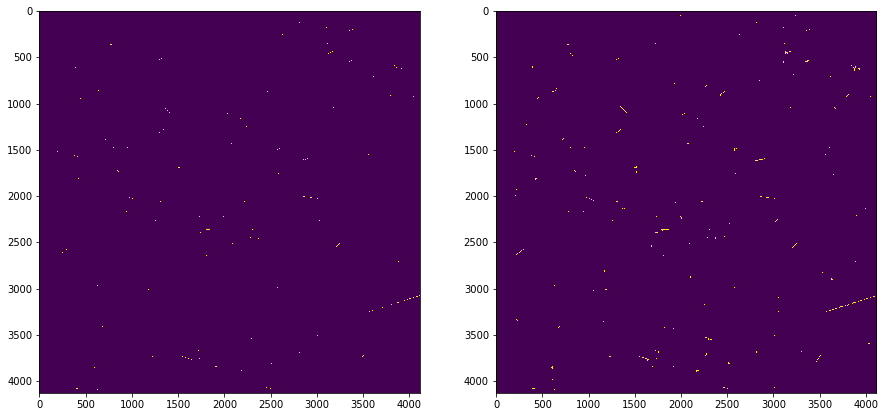

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(test["MASK"].data)
ax[1].imshow(big_test)

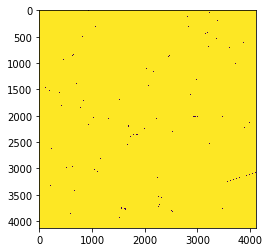

In [51]:
plt.imshow(big_test == test["MASK"].data)